In [15]:
pip install librosa numpy pandas matplotlib scikit-learn tensorflow yt-dlp ffmpeg-python pydub

In [16]:
pip install pysoundfile --upgrade

In [17]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import yt_dlp
from pydub import AudioSegment

In [18]:
def load_audio(file_path, sr=22050, duration=30):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        return y, sr
    except Exception as e:
        print(f"Error al cargar {file_path}: {e}")
        return None, None


def extract_features(file_path):
    y, sr = load_audio(file_path)

    if y is None or sr is None:
        return None

    try:
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)


        return np.hstack([
            np.mean(mfcc.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(spectral_contrast.T, axis=0),
            np.mean(zcr),
            tempo
        ])

    except Exception as e:
        print(f"Error al extraer características de {file_path}: {e}")
        return None



def prepare_dataset(dataset_path):
    data = []
    labels = []
    genres = os.listdir(dataset_path)

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        if not os.path.isdir(genre_path) or genre.startswith('.'):
            continue

        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            if not file.endswith(".wav"):
                continue
            try:
                features = extract_features(file_path)
                if features is not None:
                    data.append(features)
                    labels.append(genre)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")

    return np.array(data), np.array(labels)

In [19]:
dataset_path = "/content/drive/MyDrive/Data/genres_original"
X, y = prepare_dataset(dataset_path)
print(f"Características extraídas: {X.shape}")
print(f"Géneros detectados: {set(y)}")

scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Error al cargar /content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav: module 'soundfile' has no attribute 'SoundFileRuntimeError'
Características extraídas: (999, 34)
Géneros detectados: {'country', 'hiphop', 'pop', 'jazz', 'rock', 'classical', 'reggae', 'disco', 'blues', 'metal'}


In [20]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,)),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = create_model(X_train.shape[1], len(encoder.classes_))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2549 - loss: 2.1237 - val_accuracy: 0.4300 - val_loss: 1.5918
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4267 - loss: 1.5958 - val_accuracy: 0.4400 - val_loss: 1.4120
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5151 - loss: 1.3947 - val_accuracy: 0.5300 - val_loss: 1.2866
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5287 - loss: 1.3127 - val_accuracy: 0.6200 - val_loss: 1.1786
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5618 - loss: 1.2321 - val_accuracy: 0.6400 - val_loss: 1.1083
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6206 - loss: 1.0533 - val_accuracy: 0.6500 - val_loss: 1.0974
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6284 - loss: 1.1067 - val_accuracy: 0.6250 - val_loss: 1.0748
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6935 - loss: 0.8788 - val_accuracy: 0.6650 - v

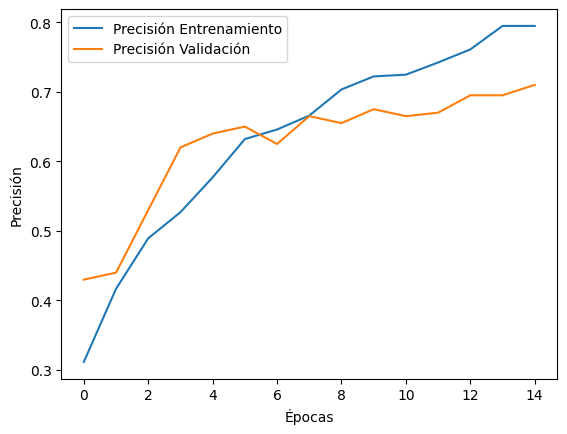

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


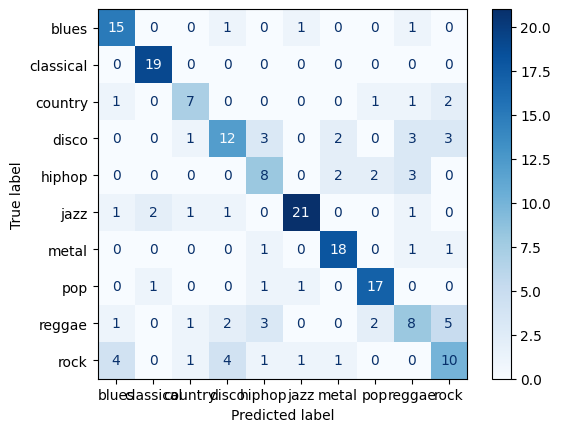

              precision    recall  f1-score   support

       blues       0.68      0.83      0.75        18
   classical       0.86      1.00      0.93        19
     country       0.64      0.58      0.61        12
       disco       0.60      0.50      0.55        24
      hiphop       0.47      0.53      0.50        15
        jazz       0.88      0.78      0.82        27
       metal       0.78      0.86      0.82        21
         pop       0.77      0.85      0.81        20
      reggae       0.44      0.36      0.40        22
        rock       0.48      0.45      0.47        22

    accuracy                           0.68       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.67      0.68      0.67       200



In [21]:
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Matriz de confusión
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

In [40]:
def download_audio_from_youtube(url, output_folder="downloads"):
    os.makedirs(output_folder, exist_ok=True)

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
        'outtmpl': f'{output_folder}/%(title)s.%(ext)s',
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)
        return os.path.join(output_folder, f"{info['title']}.wav")

In [47]:
def predict_genre(file_path, model, scaler, encoder):
    features = extract_features(file_path)
    scaled_features = scaler.transform([features])
    prediction = model.predict(scaled_features)
    genre = encoder.inverse_transform([np.argmax(prediction)])
    return genre[0]

def process_audio_file(input_path, model, scaler, encoder):
    if os.path.exists(input_path):
        print(f"Procesando archivo local: {input_path}")
        genre = predict_genre(input_path, model, scaler, encoder)
        print(f"El género de la canción es: {genre}")
    elif input_path.startswith("http://") or input_path.startswith("https://"):
        print(f"Descargando archivo desde URL: {input_path}")
        audio_path = download_audio_from_youtube(input_path)
        if audio_path and os.path.exists(audio_path):
            genre = predict_genre(audio_path, model, scaler, encoder)
            print(f"El género de la canción es: {genre}")
        else:
            print("No se pudo descargar el archivo desde la URL.")
    else:
        print("El argumento proporcionado no es ni una ruta local ni una URL válida.")

input_path = "https://www.youtube.com/watch?v=uuZE_IRwLNI"
process_audio_file(input_path, model, scaler, encoder)

Descargando archivo desde URL: https://www.youtube.com/watch?v=uuZE_IRwLNI
[youtube] Extracting URL: https://www.youtube.com/watch?v=uuZE_IRwLNI
[youtube] uuZE_IRwLNI: Downloading webpage
[youtube] uuZE_IRwLNI: Downloading ios player API JSON
[youtube] uuZE_IRwLNI: Downloading mweb player API JSON
[youtube] uuZE_IRwLNI: Downloading m3u8 information
[info] uuZE_IRwLNI: Downloading 1 format(s): 251
[download] Destination: downloads/Justin Timberlake - Mirrors (Official Video).webm
[download] 100% of    7.58MiB in 00:00:00 at 36.39MiB/s  
[ExtractAudio] Destination: downloads/Justin Timberlake - Mirrors (Official Video).wav
Deleting original file downloads/Justin Timberlake - Mirrors (Official Video).webm (pass -k to keep)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
El género de la canción es: blues
